# Running GROMACS on AQE for Polymer Simulation

This notebook will demonstrate the pipeline of creating a polymer from monomer and calculate the potential energy and other thermodynamic properties using GROMACS molecular dynamics software.

- [x] We need to load an AiiDA profile. The `load_profile` method will load the default profile if no explicit profile name is specified.

In [1]:
from aiida import load_profile
load_profile()

Profile<uuid='854b62c634cd4cd6ade4c630f3c0af0e' name='gromacs'>

We need to set some user defined parameters which will be used throughout the pipeline

In [2]:
# Polymer/Monomer inputs
monomer_pdbfilename = '14tPBMonomer.pdb'        # PDB filename of the monomer
monomer_count_per_polymer = 4                   # Number of monomers present in one polymer

polymer_count = 600                             # Number of polymers will be simulated

# MD simulation inputs
thermo_T = 300.15                               # Simulation Temperature (K)
thermo_P = 1.0                                  # Simulation Pressure (bar)

Two types of input data is required from the user.
1. Monomoer input - User will provide the name of the monomer and the number of monomers are there in a polymer they want to use in molecular dynamics simulation.

2. MD simulation inputs - User will provide an absolute thermodynamic condition for the simulation (i.e. temperature and pressure) or a range of temperature and pressure at which simulation will be conducted.

**_NOTE 1:_** A minimum intervention will be required after this.

**_NOTE 2: Currently the PoC is for linear homopolymer._**

Necessary python packages are imported in this step.

In [3]:
import pathlib
import os
import numpy as np

from aiida import engine, orm
from aiida_gromacs.utils.notebook import visualize_structure
from aiida_shell import launch_shell_job

Convert the user input into `aiida.orm` `Data` types accepted by the `node` arguments. 

In [4]:
monomer_pdbfilename = orm.Str(monomer_pdbfilename)
monomer_count_per_polymer = orm.Int(monomer_count_per_polymer)

polymer_count = orm.Int(polymer_count)

thermo_T = orm.Float(thermo_T)
thermo_P = orm.Float(thermo_P)

- [ ] Polymerization step

The monomer pdb file is opened and wrapped it in AiiDA's `SinglefieData` data type, which allows it to be stored in the provenance graph.

In [5]:
monomer = orm.SinglefileData(os.getcwd() + '/' + monomer_pdbfilename.value)

We are creating function which will take the information of each atom given in the pdb file. Atom number, atom name, residue name, residue sequence number, coordinates, elements are the information of an atom in given in the pdb file.

In [6]:
@engine.calcfunction
def get_pdbdata_to_atomdict(num: orm.Int, line: orm.Str) -> orm.Dict:
    return orm.Dict({'atom_number': num.value, 'atom_name': line.value[12:16].split()[0], \
                         'residue_name': line.value[17:20].split()[0], \
                         'residue_seq_num': int(line.value[22:26].split()[0]), \
                         'coord': [float(line.value[30:38].split()[0]), \
                                   float(line.value[38:46].split()[0]), float(line.value[46:54].split()[0])], \
                         'element': line.value[76:78].split()[0]})

<div class="alert alert-info">
 ℹ️ We are marking the function `get_pdbdata_to_atomdict` with AiiDA's `calcfunction` decorator. This ensures the act of modifying the original monomoer pdb file is captured in the provenance graph
</div>

The monomer atom information is stored in AiiDA's `List` data types, which allows it to be stored in the provenance graph. 

In [7]:
monomer_atom_lines = orm.List([line for line in monomer.get_content().split('\n') if line.startswith('ATOM') or line.startswith('HETATM')])
monomer_all_atom_list = orm.List()
for num, line in enumerate(monomer_atom_lines.get_list()):
    monomer_all_atom_list.append(get_pdbdata_to_atomdict(num, line))

We are creating some functions which will perform vector related calculations (e.g. - unit vector between 2 points.)

In [8]:
@engine.calcfunction
def get_unit_vector(p1: orm.ArrayData, p2: orm.ArrayData) -> orm.ArrayData:

    vec = p1.get_array() - p2.get_array()
    vec /= np.linalg.norm(vec)

    return orm.ArrayData(vec)

@engine.calcfunction
def get_rotation_matrix(vec1: orm.ArrayData, vec2: orm.ArrayData) -> orm.ArrayData:

    # Calculate the angle between vec1 and vec2 and rotation angle to align vec2 to vec1
    dot_product = np.dot(vec1.get_array(), vec2.get_array())
    rotation_angle = np.arccos(dot_product)
    print('rangle = ', rotation_angle)

    cos_angle = np.cos(rotation_angle)
    sin_angle = np.sin(rotation_angle)
    
    # Calculate the rotation axis (cross product)
    rotation_axis = np.cross(vec1.get_array(), vec2.get_array())
    rotation_axis /= np.linalg.norm(rotation_axis)

    rotation_matrix = np.array([
        [cos_angle + rotation_axis[0] * rotation_axis[0] * (1 - cos_angle), \
        rotation_axis[0] * rotation_axis[1] * (1 - cos_angle) - rotation_axis[2] * sin_angle, \
        rotation_axis[0] * rotation_axis[2] * (1 - cos_angle) + rotation_axis[1] * sin_angle],
        [rotation_axis[1] * rotation_axis[0] * (1 - cos_angle) + rotation_axis[2] * sin_angle, \
        cos_angle + rotation_axis[1] * rotation_axis[1] * (1 - cos_angle), \
        rotation_axis[1] * rotation_axis[2] * (1 - cos_angle) - rotation_axis[0] * sin_angle],
        [rotation_axis[2] * rotation_axis[0] * (1 - cos_angle) - rotation_axis[1] * sin_angle, \
        rotation_axis[2] * rotation_axis[1] * (1 - cos_angle) + rotation_axis[0] * sin_angle, 
        cos_angle + rotation_axis[2] * rotation_axis[2] * (1 - cos_angle)]
    ])
    return orm.ArrayData(rotation_matrix)

@engine.calcfunction
def rotate_coord(atom_coord: orm.ArrayData, ref_coord: orm.ArrayData, rotation_matrix: orm.ArrayData) -> orm.ArrayData:

    ref_atom_vec = atom_coord.get_array() - ref_coord.get_array()
    
    rotated_coord_vec = np.dot(rotation_matrix.get_array(), ref_atom_vec)
    new_atom_coord = ref_coord.get_array() + rotated_coord_vec

    return orm.ArrayData(new_atom_coord)

We are creating some functions which will perform atom dictionary related operations (e.g. - create empty atom dict.)

In [18]:
@engine.calcfunction
def copy_atomdict(curratom_dict: orm.Dict) -> orm.Dict:
    newatom_dict = orm.Dict()
    newatom_dict.set_dict(curratom_dict)
    return newatom_dict

@engine.calcfunction
def update_atom_number(curratom_dict: orm.Dict, atom_number: orm.Int) -> orm.Dict:
    newatom_dict = orm.Dict({'atom_number': atom_number.value, 'atom_name': curratom_dict['atom_name'], \
                     'residue_name': curratom_dict['residue_name'], 'residue_seq_num': curratom_dict['residue_seq_num'], \
                     'coord': curratom_dict['coord'], \
                     'element': curratom_dict['element']})
    return newatom_dict

@engine.calcfunction
def update_residue_seq_num(curratom_dict: orm.Dict, residue_seq_num: orm.Int) -> orm.Dict:
    newatom_dict = orm.Dict({'atom_number': curratom_dict['atom_number'], 'atom_name': curratom_dict['atom_name'], \
                     'residue_name': curratom_dict['residue_name'], 'residue_seq_num': residue_seq_num.value, \
                     'coord': curratom_dict['coord'], \
                     'element': curratom_dict['element']})
    return newatom_dict

@engine.calcfunction
def update_residue_name(curratom_dict: orm.Dict, residue_name: orm.Str) -> orm.Dict:
    newatom_dict = orm.Dict({'atom_number': curratom_dict['atom_number'], 'atom_name': curratom_dict['atom_name'], \
                     'residue_name': residue_name.value, 'residue_seq_num': curratom_dict['residue_seq_num'], \
                     'coord': curratom_dict['coord'], \
                     'element': curratom_dict['element']})
    return newatom_dict

@engine.calcfunction
def update_coord(curratom_dict: orm.Dict, coord: orm.List) -> orm.Dict:
    newatom_dict = orm.Dict({'atom_number': curratom_dict['atom_number'], 'atom_name': curratom_dict['atom_name'], \
                     'residue_name': curratom_dict['residue_name'], 'residue_seq_num': curratom_dict['residue_seq_num'], \
                     'coord': coord.get_list(), \
                     'element': curratom_dict['element']})
    return newatom_dict

@engine.calcfunction
def get_pdbstr(curratom_dict: orm.Dict) -> orm.Str:
    pdb_str = "ATOM  %5d %-4s %3s  %4d    %8.3f%8.3f%8.3f                      %2s" \
    % (curratom_dict['atom_number']+1, curratom_dict['atom_name'], \
       curratom_dict['residue_name'], curratom_dict['residue_seq_num']+1, \
       curratom_dict['coord'][0], curratom_dict['coord'][1], curratom_dict['coord'][2], \
       curratom_dict['element'])
    return orm.Str(pdb_str)

We are creating 2 lists here.
1. `polymer_all_atom_list`: This list contains the atom information of the whole polymer.
2. `polymer_remove_atom_index_list`: During polymerization one hydrogens at the connecting carbon atoms of 2 monomers will be removed during the polimerization process.

**_NOTE 1: `polymer_remove_atom_index_list` list will be._**

In [22]:
polymer_all_atom_list = orm.List()
polymer_remove_atom_index_list = orm.List()

# Add monomers to the polymer chain
polymer_atom_count = 0
for imonomer in range(monomer_count_per_polymer.value):
    monomer_atom_count = len(monomer_all_atom_list)
    # first monomer
    if imonomer == 0:
        for iatom in monomer_all_atom_list:
            curratom = copy_atomdict(iatom)
            curratom = update_atom_number(curratom, orm.Int(polymer_atom_count))
            curratom = update_residue_seq_num(curratom, orm.Int(imonomer))
            
            polymer_all_atom_list.append(curratom)
            
            if iatom['atom_name'] == 'HW3':
                polymer_remove_atom_index_list.append(polymer_all_atom_list[len(polymer_all_atom_list)-1]['atom_number'])
            polymer_atom_count += 1
    else:
        # get the CW of last monomer
        cw_index = -1
        for iatom in polymer_all_atom_list:
            if iatom['atom_name'] == 'CW':
                cw_index = iatom['atom_number']

        if cw_index < 0:
            raise ValueError('CW atom is not found.')
        
        # get the HA3 of model monomer
        ha3_index = -1
        for iatom in monomer_all_atom_list:
            if iatom['atom_name'] == 'HA3':
                ha3_index = iatom['atom_number']
                
        if ha3_index < 0:
            raise ValueError('HA3 atom is not found.')

        dtranslate = np.array(polymer_all_atom_list[cw_index]['coord']) \
        - np.array(monomer_all_atom_list[ha3_index]['coord'])
                    
        # put the next monomer in the polymer + translation
        for iatom in monomer_all_atom_list:
            curratom = copy_atomdict(iatom)
            curratom = update_atom_number(curratom, orm.Int(polymer_atom_count))
            curratom = update_residue_seq_num(curratom, orm.Int(imonomer))

            coord = np.array(iatom['coord']) + dtranslate
            curratom = update_coord(curratom, orm.List(coord.tolist()))

            if imonomer != monomer_count_per_polymer.value - 1:
                curratom = update_residue_name(curratom, orm.Str(iatom['residue_name'][:-1] + '2'))
            else:
                curratom = update_residue_name(curratom, orm.Str(iatom['residue_name'][:-1] + '3'))
            
            polymer_all_atom_list.append(curratom)
            
            if polymer_all_atom_list[len(polymer_all_atom_list)-1]['atom_name'] == 'HA3':
                polymer_remove_atom_index_list.append(polymer_all_atom_list[len(polymer_all_atom_list)-1]['atom_number'])
            elif polymer_all_atom_list[len(polymer_all_atom_list)-1]['atom_name'] == 'HW3':
                if polymer_all_atom_list[len(polymer_all_atom_list)-1]['residue_seq_num'] != monomer_count_per_polymer.value - 1:
                    polymer_remove_atom_index_list.append(polymer_all_atom_list[len(polymer_all_atom_list)-1]['atom_number'])
                    
            polymer_atom_count += 1

        # rotation starts here
        # CW.coord == HA3.coord
        # get the CA of last monomer
        ca_index = -1
        for iatom in polymer_all_atom_list:
            if iatom['atom_name'] == 'CA':
                ca_index = iatom['atom_number']
                
        if ca_index < 0:
            raise ValueError('CA atom is not found.')

        # get the HW3 of previous monomer
        hw3_index = -1
        for iatom in polymer_all_atom_list:
            if iatom['atom_name'] == 'HW3' and iatom['residue_seq_num'] == imonomer - 1:
                hw3_index = iatom['atom_number']
                
        if hw3_index < 0:
            raise ValueError('HW3 atom is not found.')

        cw_hw3_unit_vec = get_unit_vector(orm.ArrayData(np.array(polymer_all_atom_list[hw3_index]['coord'])), \
                              orm.ArrayData(np.array(polymer_all_atom_list[cw_index]['coord'])))

        cw_ca_unit_vec = get_unit_vector(orm.ArrayData(np.array(polymer_all_atom_list[ca_index]['coord'])), \
                              orm.ArrayData(np.array(polymer_all_atom_list[cw_index]['coord'])))

        rotation_matrix = get_rotation_matrix(cw_hw3_unit_vec, cw_ca_unit_vec)

        for index, iatom in enumerate(polymer_all_atom_list):
            if iatom['residue_seq_num'] == imonomer and iatom['atom_name'] != '':
                coord = rotate_coord(orm.ArrayData(np.array(iatom['coord'])), \
                                               orm.ArrayData(np.array(polymer_all_atom_list[ca_index]['coord'])), \
                                              rotation_matrix).get_array().tolist()
                polymer_all_atom_list[index] = update_coord(polymer_all_atom_list[index], coord)

As we get the complete atom information of the polymer, we can wrap this data in AiiDA's `SinglefileData` data type, which will allows it to be stored in the provenance graph.

In [23]:
polymer_all_atom_lines = orm.List()
for iatom in polymer_all_atom_list:
    if iatom['atom_number'] not in polymer_remove_atom_index_list.get_list():
        polymer_all_atom_lines.append(get_pdbstr(iatom).value)
polymer = orm.SinglefileData.from_string('\n'.join(polymer_all_atom_lines), filename='polymer.pdb')

The `gmx pdb2gmx` is the first GROMACS command to create th topology file according to the forcefield information for the polymer.

In [24]:
@engine.calcfunction
def calc_molecular_weight_polymer(polymer: orm.SinglefileData) -> orm.Float:
    import pandas as pd
    elecsvfile = os.getcwd() + '/elements.csv'
    dataframe_elements = pd.read_csv(elecsvfile, index_col = None)
    
    atom_lines = polymer.get_content().split('\n')

    # Calculate molecular weight
    molecular_weight_polymer = 0.0
    for line in atom_lines:
        # Find element and atomic mass from the periodic table
        ele = line[76:78].split()[0]

        try:
            molecular_weight_polymer += float(dataframe_elements.loc[dataframe_elements['Symbol'] == ele, 'AtomicMass'].iloc[0])
        except:
            raise Exception(f'ERROR: Atom type of {elestr} not found.')

    return orm.Float(molecular_weight_polymer)

@engine.calcfunction
def calc_simulation_box_length(molecular_weight_polymer: orm.Float, polymer_count: orm.Int) -> orm.Float:
    molecular_weight = molecular_weight_polymer.value * polymer_count.value
    
    # Default density (0.4 g/cm3)
    density = 0.4
    avogadro_number = 6.022e23  # molecules/mol
    cm_to_nm = 1e7  # cm to nm conversion factor
    
    # Step 1: Mass of one molecule
    mass_per_molecule = molecular_weight / avogadro_number  # g
    
    # Step 2: Volume of cubic box
    volume = mass_per_molecule / density  # cm³
    
    # Step 3: Side length of the cubic box
    box_length = volume**(1/3)  # cm
    box_length = box_length * cm_to_nm  # nm

    return orm.Float(box_length)

molecular_weight_polymer = calc_molecular_weight_polymer(polymer)
box_length = calc_simulation_box_length(molecular_weight_polymer, polymer_count)

We are setting the force-field folder and wrap it in AiiDA's `FolderData` data type, which allows it to be stored in the provenance graph.

In [25]:
# Default Parameters
ffdir = os.getcwd() + '/oplsaa.ff'
oplsaa = orm.FolderData(tree=ffdir)                       

In [27]:
# Run `gmx pdb2gmx` to convert the PDB to GROMACS .gro format.
results_pdb2gmx, node_pdb2gmx = launch_shell_job(
    'gmx',
    arguments='pdb2gmx -f {polymer} -o polymer_out.pdb -water spce -ff oplsaa',
    nodes={
        'polymer': polymer,
        'folder': oplsaa,
    },
    filenames={
        'folder': 'oplsaa.ff'
    },
    outputs=['polymer_out.pdb', 'topol.top', 'posre.itp'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_pdb2gmx['stdout'].get_content())

<div class="alert alert-info">
`gmx` is the GROMACS executable which will be executed with several parameters. The `nodes` argument takes a dictionary of `SinglefileData` and `FolderData` which will be copied to the working directory where the `gmx` command is executed. The `oplsaa` in `nodes` are copied to the `oplsaa.ff` folder in the working directory. If the key of the node appears as a placeholder in the `arguments` argument, it is replaced with its filename. 
</div>

The `gmx pdb2gmx` is expected to generate three outputs of interest:
- `polymer_out.pdb`: `.pdb` file of the polymer.
- `topol.top`: The topology file.
- `posre.itp`: The position restraint file included in the topology file.

<div class="alert alert-info">
These output files will be used in the upcoming steps in the pipeline. To capture these output files in the AiiDA's provenance graph, these filenames are declared in the `output` argunent. `aiida-shell` will wrap these output files in a `SinglefileDtata`.
</div>

Similar to the previous steps, GROMACS creates a simulation box where mutiple chains of the polymer will be inserted for the MD simulations. From the previous step, `.pdb` file of the single polymer chain is used to replicate the polymer chain inside the simulation box. In the output, we get a simulation box containing `polymer_count` number of polymers.

In [29]:
@engine.calcfunction
def check_insert_molecules(log: orm.SinglefileData, polymer_count: orm.Int) -> orm.Bool:
    lines = log.get_content().split('\n')
    check_lines = [line for line in lines if line.startswith('Added')]
    
    if len(check_lines) > 1:
        raise Exception('ERROR: Multiple lines got selected in the check_lines variable', check_lines)

    wordlist = check_lines[0].split()
    polymer_count_inserted = orm.Int(wordlist[1])
    
    if polymer_count_inserted.value == polymer_count.value:
        return orm.Bool(False)
    else:
        return orm.Bool(True)

run = orm.Bool(True)
while run.value:
    results_insert, node_insert = launch_shell_job(
        'gmx',
        arguments='insert-molecules -box {box_length} -ci {polymer} -nmol {polymer_count} -try 999 -o melt.pdb',
        nodes={
            'box_length': box_length,
            'polymer': polymer,
            'polymer_count': polymer_count,
        },
        outputs=['melt.pdb'],
        metadata={'options': {'redirect_stderr': True}},
    )
    #print(results_insert['stdout'].get_content())
    run = check_insert_molecules(results_insert['stdout'], polymer_count)
    if run.value:        
        run = orm.Bool(False)
        print('Rerun')
    else:
        run = orm.Bool(False)
        print('Success')

While running the `pdb2gmx` command we have created the topology for one single polymer chain. However, in the `topol.top` file we have to provide the number of polymer chain present in the simulation box. Therefore, we are updating the number of molecules line from 1 to `polymer_count` using the `sed` command.

In [32]:
results_updatetop, node_updatetop = launch_shell_job(
    'sed',
    arguments='-i "s/Other               1/Other               {polymer_count}/g" {top}',
    nodes={
        'polymer_count': polymer_count,
        'top': results_pdb2gmx['topol_top'],
    },
    outputs=['topol.top'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_updatetop['stdout'].get_content())

<div class="alert alert-info">
The output `topol.top` file is declared in the `output` argunent where `aiida-shell` will wrap these output files in a `SinglefileDtata`.
</div>

**Prerequisite for MD simulations and simulation box preparation is completed and we can proceed to run the molecular dynamics simulation.**

In [33]:
em_mdp = orm.SinglefileData.from_string(
    """
    integrator      = steep
    emtol           = 1000.0
    emstep          = 0.01
    nsteps          = 50000
    nstlist         = 1
    cutoff-scheme   = Verlet
    ns_type         = grid
    coulombtype     = PME
    rcoulomb        = 1.0
    rvdw            = 1.0
    pbc             = xyz
    ld_seed         = 1
    gen_seed        = 1
    """,
    filename='em.mdp',
)

# Run `gmx grompp` to pre-process the parameters for energy minimization.
results_grompp_em, node_grompp_em = launch_shell_job(
    'gmx',
    arguments='grompp -f {mdp} -c {gro} -p {top} -o output.tpr',
    nodes={
        'mdp': em_mdp,
        'gro': results_insert['melt_pdb'],
        'top': results_updatetop['topol_top'],
        'folder': oplsaa,
    },
    filenames={
        'folder': 'oplsaa.ff'
    },
    outputs=['output.tpr'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_grompp_em['stdout'].get_content())

The `gmx grompp` takes the input of three necesary files to generate the `.tpr` file.
- [x] `.mdp`: The molecular dynamics parameters.
- [x] `.gro`: The coordinate information of all the polymer chains present in the simulation box.
- [x] `.top`: The tolology file of the polymer. Also, this has the information of number of polymers present in the simulation box.

The generated `.tpr` file is used for running the molecular dynamics simulation. We can run the `gmx mdrun` to run the energy minimization step.

In [35]:
# Run `gmx mdrun` to run the energy minimization.
results_em, node_em = launch_shell_job(
    'gmx',
    arguments='mdrun -v -deffnm output -s {tpr}',
    nodes={
        'tpr': results_grompp_em['output_tpr'],
    },
    outputs=['output.edr', 'output.gro', 'output.log'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_em['stdout'].get_content())

Similar to the previous `gmx grompp` step, we can proceed with NPT equilibration step where the molecular dynamics simulation will be performed at the given thermodynamic conditions given by the user.

In [36]:
eqnpt_mdp = orm.SinglefileData.from_string(
    """
    title                   = NPT Equilibration
    ;define                 = -DPOSRES
    integrator              = md
    dt                      = 0.002
    nsteps                  = 50000
    nstenergy               = 2000
    nstxout-compressed      = 10000
    nstvout                 = 0
    nstlog                  = 1000
    gen_vel                 = yes
    gen_temp                = 298.15
    pbc                     = xyz
    cutoff-scheme           = Verlet
    rlist                   = 1.0
    ns_type                 = grid
    nstlist                 = 10
    coulombtype             = PME
    fourierspacing          = 0.12
    pme_order               = 4
    rcoulomb                = 1.0
    vdwtype                 = Cut-Off
    rvdw                    = 1.0
    DispCorr                = EnerPres
    constraints             = h-bonds
    constraint_algorithm    = lincs
    lincs_iter              = 1
    lincs_order             = 4
    tcoupl                  = v-rescale
    tc-grps                 = System
    ref_t                   = 298.15
    tau_t                   = 0.1
    pcoupl                  = c-rescale
    pcoupltype              = isotropic
    ref_p                   = 1.0
    tau_p                   = 2.0
    ;refcoord-scaling        = com
    compressibility         = 4.5e-5
    """,
    filename='eqnpt.mdp',
)

# Run `gmx grompp` to pre-process the parameters for energy minimization.
results_grompp_eqnpt, node_grompp_eqnpt = launch_shell_job(
    'gmx',
    arguments='grompp -f {mdp} -c {gro} -p {top} -o npt.tpr',
    nodes={
        'mdp': eqnpt_mdp,
        'gro': results_em['output_gro'],
        'top': results_updatetop['topol_top'],
        'folder': oplsaa,
    },
    filenames={
        'folder': 'oplsaa.ff'
    },
    outputs=['npt.tpr'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_grompp_eqnpt['stdout'].get_content())

The generated `.tpr` file is used for running the molecular dynamics simulation for NPT equilibration. We can run the `gmx mdrun` to run the NPT equilibration step.

In [37]:
# Run `gmx mdrun` to run the energy minimization.
results_eqnpt, node_eqnpt = launch_shell_job(
    'gmx',
    arguments='mdrun -v -deffnm output -s {tpr}',
    nodes={
        'tpr': results_grompp_eqnpt['npt_tpr'],
    },
    outputs=['output.edr', 'output.gro', 'output.log', 'output.xtc'],
    metadata={'options': {'redirect_stderr': True}},
)
#print(results_eqnpt['stdout'].get_content())

**MD simulation is completed. Therefore, we can go for analysis of the simulated system.**

<div class="alert alert-info">
Using `gmx energy` command we can calculate and plot the primary properties for the simulated polymer system.
</div>

In [38]:
# Run `gmx energy` to extract the potential energy during the energy minimization.
results_energy, node_energy = launch_shell_job(
    'gmx',
    arguments='energy -f {edr} -o potential.xvg',
    nodes={
        'edr': results_eqnpt['output_edr'],
        'stdin': orm.SinglefileData.from_string('10\n0'),
    },
    outputs=['potential.xvg'],
    metadata={'options': {'redirect_stderr': True, 'filename_stdin': 'stdin'}},
)

<div class="alert alert-info">
The input for `gmx energy` is the `output.edr` from the `results_eqnpt`. Here we first pass `10` which corresponds to the potential energy, followed by `0` which finalizes the selection and completes the prompt. The `output` file of this step saved as GROMACS generated `.xvg` format.
</div>

To visualize the data, first we need to import necessary python packages to be installed.

In [39]:
import io

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, IFrame

We define the `create_plot` function and pass the `potential.xvg` from the previous step. The `create_plot` will create a plot which is saved to a stream in memory which is then passed to a `SinglefileData` node to store it in AiiDA's provecance graph.

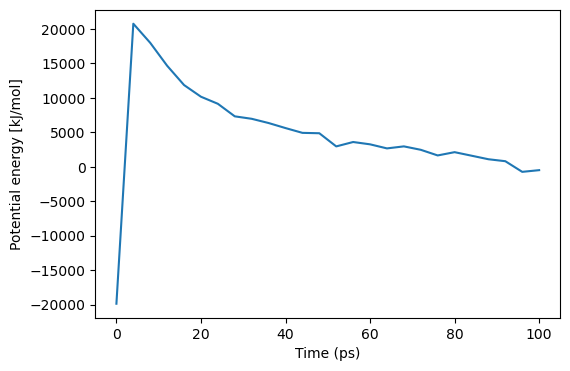

In [40]:
@engine.calcfunction
def create_plot(xvg: orm.SinglefileData) -> orm.SinglefileData:
    """Plot the data of a XVG output file."""
    lines = xvg.get_content().split('\n')
    data = np.loadtxt(lines, comments=['#', '@']).T
    plt.figure(figsize=(6,4))
    plt.plot(*data)
    plt.xlabel('Time (ps)')
    plt.ylabel('Potential energy [kJ/mol]')
    stream = io.BytesIO()
    plt.savefig(stream, format='png', bbox_inches='tight', dpi=150)
    #stream.seek(0)
    return orm.SinglefileData(stream, filename='potential.png')
    
# Create a plot from the extracted potential energy of the system
plot = create_plot(results_energy['potential_xvg'])

In the same way we can get the density data from the `output.edr` using the `gmx energy` command and plot it.

In [41]:
# Run `gmx energy` to extract the potential energy during the energy minimization.
results_energy, node_energy = launch_shell_job(
    'gmx',
    arguments='energy -f {edr} -o density.xvg',
    nodes={
        'edr': results_eqnpt['output_edr'],
        'stdin': orm.SinglefileData.from_string('22\n0'),
    },
    outputs=['density.xvg'],
    metadata={'options': {'redirect_stderr': True, 'filename_stdin': 'stdin'}},
)

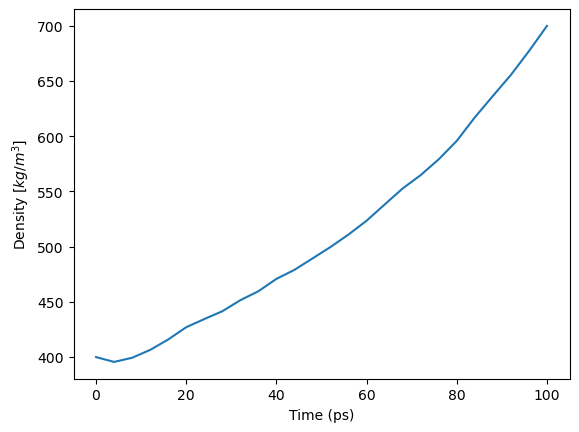

In [42]:
@engine.calcfunction
def create_plot(xvg: orm.SinglefileData) -> orm.SinglefileData:
    """Plot the data of a XVG output file."""
    lines = xvg.get_content().split('\n')
    data = np.loadtxt(lines, comments=['#', '@']).T
    plt.plot(*data)
    plt.xlabel('Time (ps)')
    plt.ylabel('Density $[kg/m^3]$')
    stream = io.BytesIO()
    plt.savefig(stream, format='png', bbox_inches='tight', dpi=300)
    #stream.seek(0)
    return orm.SinglefileData(stream, filename='density.png')

# Create a plot from the extracted density of the system
plot = create_plot(results_energy['density_xvg'])

In [39]:
from aiida.engine.daemon.client import get_daemon_client

client = get_daemon_client()
client.start_daemon()